In [111]:
from keras.layers import Input, Dense, Flatten
from keras.layers.core import Activation
from keras.models import Model, Sequential
from keras import regularizers, optimizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import os
import statistics
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pd.set_option("display.max_columns", None)

# data engineering

In [2]:
benign_path = '/home/sdsra/Downloads/CTU-Dataset/benign'
benign_datas = pd.DataFrame()
sub_dir_list = os.listdir(benign_path)
for dir in sub_dir_list:
    tmp_data = pd.read_pickle(benign_path + '/' + dir + '/datas-by-origin-tool.pkl')
    benign_datas = pd.concat([benign_datas, tmp_data], ignore_index=True)

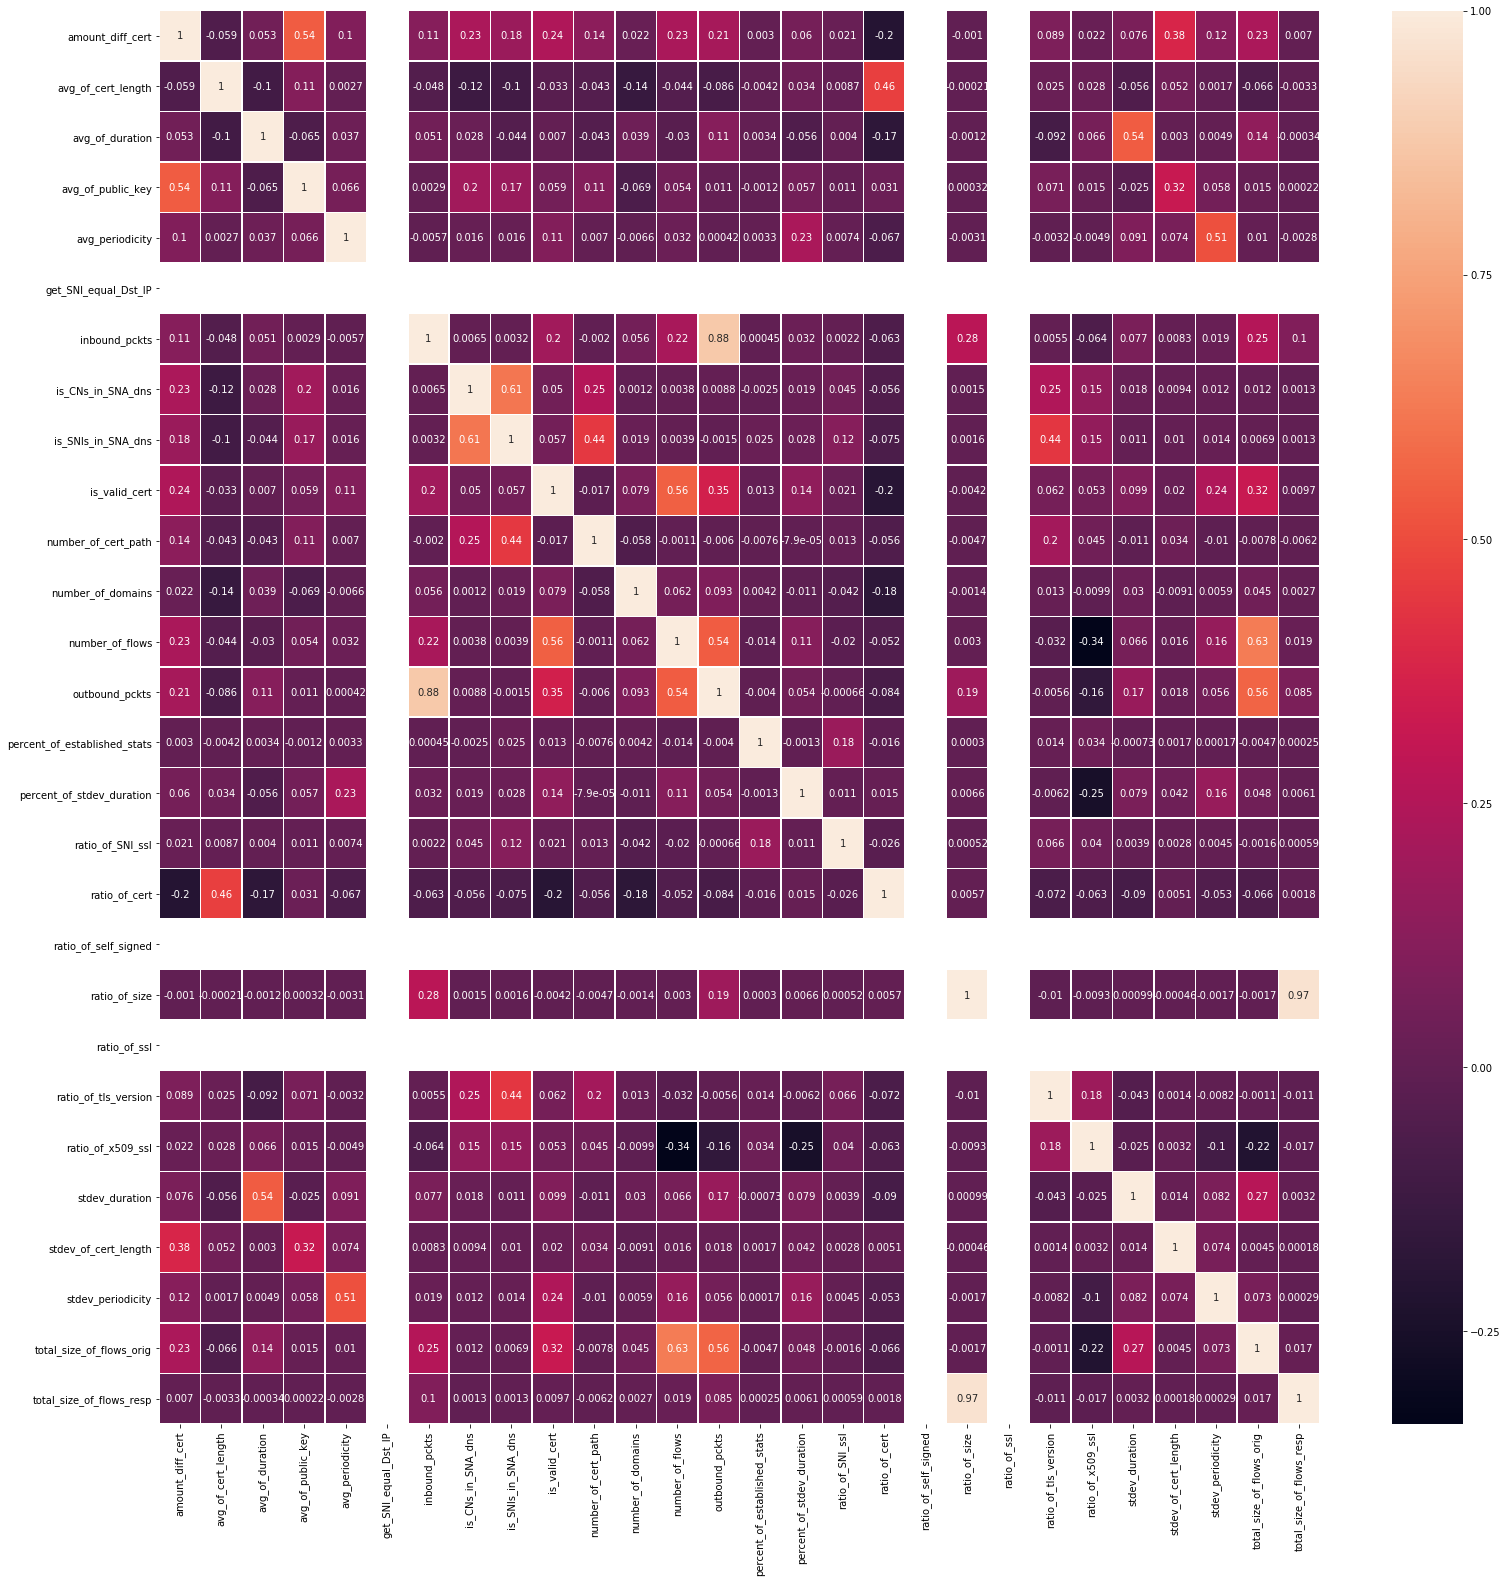

In [3]:
plt.figure(figsize=(26, 26))
sns.heatmap(benign_datas.corr(), annot=True, linewidths=.5)

In [33]:
benign_datas['get_SNI_equal_Dst_IP'].value_counts()

0    12971
Name: get_SNI_equal_Dst_IP, dtype: int64

In [4]:
malware_path = '/home/sdsra/Downloads/CTU-Dataset/malware-2' 
malware_datas = pd.DataFrame()
for dir in os.listdir(malware_path) :
    pkl_path = malware_path +'/'+dir+'/datas-by-origin-tool.pkl'
    if os.path.exists(pkl_path):
        tmp_data = pd.read_pickle(pkl_path)
        malware_datas = pd.concat([malware_datas, tmp_data], ignore_index=True)

In [5]:
malware_datas = malware_datas[malware_datas['label'] == 'botnet']

In [6]:
benign_datas['is_normal'] = 1

In [7]:
malware_datas['is_normal'] = -1

In [8]:
numeric_columns = list(filter(lambda x: x not in ['src_ip','src_port','dst_ip','dst_port','proto', 'label', 'is_malware'], benign_datas.columns))

In [9]:
datas = benign_datas.sample(len(malware_datas), replace=True)

In [10]:
datas_train, datas_test = train_test_split(datas,test_size=0.2, random_state = 101)

In [11]:
minmax_scaler = MinMaxScaler()

In [12]:
scaled_X_train = minmax_scaler.fit_transform(datas_train[numeric_columns])

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
scaled_X_test = minmax_scaler.transform(datas_test[numeric_columns])

# OC SVM

In [14]:
clf = OneClassSVM(nu=0.1, kernel='rbf', gamma=0.1)

In [15]:
clf.fit(scaled_X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [134]:
clf

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

# test malware data

In [135]:
scaled_malware = minmax_scaler.transform(malware_datas[numeric_columns])

In [136]:
y_pred_train = clf.predict(scaled_X_train)
y_pred_test = clf.predict(scaled_X_test)
y_pred_outliers = clf.predict(scaled_malware)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

In [19]:
malware_pred = clf.predict(scaled_malware_data)

In [20]:
malware_datas['ocsvm_pred'] = malware_pred

In [21]:
compare_datas = pd.concat([datas_test, malware_datas], ignore_index=True)

In [95]:
compare_datas['is_normal'].value_counts()

-1    71409
 1    14282
Name: is_normal, dtype: int64

In [22]:
pred_is_malware = compare_datas['ocsvm_pred'].apply(lambda x : 1 if x == -1 else 0)

In [23]:
real_is_malware = compare_datas['is_normal'].apply(lambda x : 1 if x == -1 else 0)

In [24]:
cm = confusion_matrix(real_is_malware, pred_is_malware)

In [25]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [26]:
cm

array([[0.896163, 0.103837],
       [0.      , 1.      ]])

In [27]:
TN, FP, FN, TP  = cm.ravel()

In [28]:
accuracy = (TN + TP) / (TN + TP + FP + FN)
precision = TP / (TP + FP)

In [29]:
print('accuracy : {}, precision: {}'.format(accuracy, precision))

accuracy : 0.9480815011903094, precision: 0.9059308594988899


# Visualization

In [49]:
from sklearn.decomposition import PCA

In [51]:
scaled_compare_datas = minmax_scaler.transform(compare_datas[numeric_columns])

In [67]:
y_real = compare_datas['is_normal']

In [77]:
df_rslt = clf.decision_function(scaled_compare_datas)

In [90]:
compare_datas['df_rslt'] = df_rslt

In [91]:
compare_datas.describe()

,amount_diff_cert,avg_of_cert_length,avg_of_duration,avg_of_public_key,avg_periodicity,get_SNI_equal_Dst_IP,inbound_pckts,is_CNs_in_SNA_dns,is_SNIs_in_SNA_dns,is_valid_cert,number_of_cert_path,number_of_domains,number_of_flows,outbound_pckts,percent_of_established_stats,percent_of_stdev_duration,ratio_of_SNI_ssl,ratio_of_cert,ratio_of_self_signed,ratio_of_size,ratio_of_ssl,ratio_of_tls_version,ratio_of_x509_ssl,stdev_duration,stdev_of_cert_length,stdev_periodicity,total_size_of_flows_orig,total_size_of_flows_resp,is_normal,ocsvm_pred,df_rslt
count,85691.000000,85691.000000,85691.000000,8.569100e+04,8.569100e+04,85691.0,8.569100e+04,85691.000000,85691.000000,85691.000000,85691.000000,85691.000000,85691.000000,8.569100e+04,85691.000000,85691.000000,85691.000000,85691.000000,85691.000000,85691.000000,85691.0,85691.000000,85691.000000,85691.000000,85691.000000,85691.000000,8.569100e+04,8.569100e+04,85691.000000,85691.000000,85691.000000
mean,1.189320,494.580929,56.850576,2.390877e+03,7.502804e+03,0.0,1.769241e+02,0.849949,0.899768,3.180824,2.409098,9.725234,6.543721,9.369148e+01,0.999990,0.113490,0.985403,-71.534671,0.060670,82.666406,0.0,0.955308,0.888061,7.927348,6.407787,2994.518021,8.402462e+03,2.442228e+05,-0.666663,-0.701276,-1656.528669
std,3.167034,424.010398,156.398798,6.543081e+03,3.914185e+04,0.0,5.277032e+03,0.466157,0.428423,192.274548,1.022204,24.837679,762.759384,4.684172e+03,0.001132,0.196713,0.088381,76.998314,0.237724,2732.415014,0.0,0.204395,0.262069,103.508460,48.527382,19474.197422,4.575544e+05,1.659939e+07,0.745364,0.712895,1083.818427
min,0.000000,-1.000000,0.002729,-1.000000e+00,-1.000000e+00,0.0,1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,3.000000e+00,0.800000,0.000000,0.000000,-8758.962190,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-1.000000,-1.000000,9.000000e+01,0.000000e+00,-1.000000,-1.000000,-5194.351348
25%,1.000000,90.000000,6.094328,2.048000e+03,-1.000000e+00,0.0,2.200000e+01,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.400000e+01,1.000000,0.000000,1.000000,-90.891857,0.000000,9.788954,0.0,1.000000,1.000000,0.000000,0.000000,-1.000000,8.050000e+02,1.129600e+04,-1.000000,-1.000000,-1708.990650
50%,1.000000,365.000000,39.624952,2.048000e+03,-1.000000e+00,0.0,4.200000e+01,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.400000e+01,1.000000,0.000000,1.000000,-45.403277,0.000000,16.578313,0.0,1.000000,1.000000,0.000000,0.000000,-1.000000,1.070000e+03,2.592900e+04,-1.000000,-1.000000,-1692.841935
75%,1.000000,790.000000,89.773420,2.048000e+03,-1.000000e+00,0.0,9.500000e+01,1.000000,1.000000,2.000000,3.000000,4.000000,2.000000,4.500000e+01,1.000000,0.200000,1.000000,-15.829643,0.000000,73.163857,0.0,1.000000,1.000000,0.420946,0.000000,-1.000000,1.871000e+03,9.578500e+04,-1.000000,-1.000000,-1683.706801
max,554.000000,9998.000000,41797.101910,1.134592e+06,1.359972e+06,0.0,1.325714e+06,1.000000,1.000000,48446.000000,24.000000,892.000000,220976.000000,1.301618e+06,1.000000,1.000000,1.000000,0.999319,1.000000,545611.062348,0.0,1.000000,1.000000,26969.504100,4954.500000,712997.005884,8.200282e+07,3.360419e+09,1.000000,1.000000,153.357959


In [93]:
compare_datas['Index'] = compare_datas.index

In [96]:
from sklearn.decomposition import TruncatedSVD

In [97]:
svd = TruncatedSVD().fit_transform(scaled_compare_datas)

In [101]:
len(df_rslt)

85691

In [100]:
len(svd)

85691

In [113]:
compare_datas['svd_x'] = svd[:,0]

In [114]:
compare_datas['svd_y'] = svd[:,1]

In [115]:
compare_datas['df_rslt'] = df_rslt

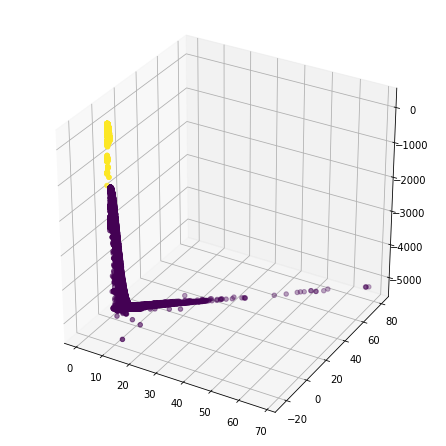

In [127]:
# ax.scatter(svd[:,0], svd[:,1], df_rslt, c=compare_datas['is_normal'], marker='o')
ax = Axes3D(plt.figure(figsize=(6,6)))
ax.scatter(svd[:,0], svd[:,1], df_rslt, c=compare_datas['is_normal'], marker='o')

In [106]:
svd[:,1]

array([-1.4075669 , -1.38671552, -1.39479968, ..., -1.99302073,
       -1.99302134, -1.99302081])

# My benign data

In [30]:
my_captured_datas = pd.read_pickle('/home/sdsra/Downloads/Dataset/capture_by_me/datas-final-by-origin-tool.pkl')

In [31]:
my_captured_datas['is_normal'] = 1

In [32]:
scaled_my_capture_data = minmax_scaler.transform(my_captured_datas[numeric_columns])

In [33]:
my_capture_pred = clf.predict(scaled_my_capture_data)

In [34]:
my_catpure_pred_is_malware = pd.Series(my_capture_pred).apply(lambda x : 1 if x == -1 else 0)

In [35]:
my_capture_real = my_captured_datas['is_normal']

In [36]:
my_catpure_real_is_malware =  my_captured_datas['is_normal'].apply(lambda x : 1 if x == -1 else 0)

In [37]:
cm = confusion_matrix(my_catpure_real_is_malware, my_catpure_pred_is_malware)

In [38]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [39]:
cm

array([[0.8034188, 0.1965812],
       [      nan,       nan]])